National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Large Scale Machine Learning — 1

Final Project: User routes on the site

Student: Andrei Batyrov (Fall2022)

Date: 15-Jan-2024

##### Table of Contents

[Description](#description)

[Spark SQL Solution](#solution)

1. [Load Data](#load-data)

2. [Main Part](#main-part)

3. [Save Result](#save-result)

4. [Summary](#summary)

# User routes on the site
## <a id="description"></a> Description
**Clickstream** is a sequence of user actions on a website. It allows you to understand how users interact with the site. In this task, you need to find the most frequent custom routes.

## Input data
Input data is а table with clickstream data in file `hdfs:/data/clickstream.csv`.

### Table structure
* `user_id (int)` - Unique user identifier.
* `session_id (int)` - Unique identifier for the user session. The user's session lasts until the identifier changes.
* `event_type (string)` - Event type from the list:
    * **page** - visit to the page
    * **event** - any action on the page
    * <b>&lt;custom&gt;</b> - string with any other type
* `event_page (string)` - Page on the site.
* `timestamp (int)` - Unix-timestamp of action.

### Browser errors
Errors can sometimes occur in the user's browser - after such an error appears, we can no longer trust the data of this session and all the following lines after the error or at the same time with it are considered corrupted and **should not be counted** in statistics.

When an error occurs on the page, a random string containing the word **error** will be written to the `event_type` field.

### Sample of user session
<pre>
+-------+----------+------------+----------+----------+
|user_id|session_id|  event_type|event_page| timestamp|
+-------+----------+------------+----------+----------+
|    562|       507|        page|      main|1620494781|
|    562|       507|       event|      main|1620494788|
|    562|       507|       event|      main|1620494798|
|    562|       507|        page|    family|1620494820|
|    562|       507|       event|    family|1620494828|
|    562|       507|        page|      main|1620494848|
|    562|       507|wNaxLlerrorU|      main|1620494865|
|    562|       507|       event|      main|1620494873|
|    562|       507|        page|      news|1620494875|
|    562|       507|        page|   tariffs|1620494876|
|    562|       507|       event|   tariffs|1620494884|
|    562|       514|        page|      main|1620728918|
|    562|       514|       event|      main|1620729174|
|    562|       514|        page|   archive|1620729674|
|    562|       514|        page|     bonus|1620729797|
|    562|       514|        page|   tariffs|1620731090|
|    562|       514|       event|   tariffs|1620731187|
+-------+----------+------------+----------+----------+
</pre>

#### Correct user routes for a given user:
* **Session 507**: main-family-main
* **Session 514**: main-archive-bonus-tariffs

Route elements are ordered by the time they appear in the clickstream, from earliest to latest.

The route must be accounted for completely before the end of the session or an error in the session.

## Task
You need to use the Spark SQL, Spark RDD and Spark DF interfaces to create a solution file, the lines of which contain **the 30 most frequent user routes** on the site.

Each line of the file should contain the `route` and `count` values **separated by tabs**, where:
* `route` - route on the site, consisting of pages separated by "-".
* `count` - the number of user sessions in which this route was.

The lines must be **ordered in descending order** of the `count` field.

## Criteria
You can get maximum of 3.5 points (final grade) for this assignment, depedning on the number of interface you manage to leverage. The criteria are as follows:

* 0.5 points – Spark SQL solution with 1 query
* 0.5 points – Spark SQL solution with <=2 queries
* 0.5 points – Spark RDD solution
* 0.5 points – Spark DF solution
* 0.5 points – your solution algorithm is relatively optimized, i.e.: no O^2 or O^3 complexities; appropriate object usage; no data leaks etc. This is evaluated by staff.
* 1 point – 1 on 1 screening session. During this session staff member can ask you questions regarding your solution logic, framework usage, questionable parts of your code etc. If your code is clean enough, the staff member can just ask you to solve a theoretical problem connected to Spark.


## <a id="solution"></a> Spark SQL Solution

In [22]:
# Essential import
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [23]:
# Init
findspark.init()
sc = pyspark.SparkContext(appName="sga")
se = SparkSession(sc)

2024-01-15 14:24:07,261 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


##### <a id="load-data"></a> Load Data

In [24]:
# (1) Put data to HDFS, if it's not already there
! hdfs dfs -put ./clickstream.csv /data/clickstream.csv
! hdfs dfs -ls /data/clickstream.csv

put: `/data/clickstream.csv': File exists
-rw-r--r--   1 root supergroup   32241574 2023-09-24 20:38 /data/clickstream.csv


In [25]:
# (2) Load data
# Cache the data to speed up future actions
filename = "/data/clickstream.csv"
data = se.read.csv(filename, header=True, sep="\t").cache()

In [26]:
data.count()

1000000

In [27]:
data.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_page: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [28]:
data.show(10)

+-------+----------+------------+----------+----------+
|user_id|session_id|  event_type|event_page| timestamp|
+-------+----------+------------+----------+----------+
|    562|       507|        page|      main|1695584127|
|    562|       507|       event|      main|1695584134|
|    562|       507|       event|      main|1695584144|
|    562|       507|       event|      main|1695584147|
|    562|       507|wNaxLlerrorU|      main|1695584154|
|    562|       507|       event|      main|1695584154|
|    562|       507|       event|      main|1695584154|
|    562|       507|       event|      main|1695584160|
|    562|       507|        page|    rabota|1695584166|
|    562|       507|       event|    rabota|1695584174|
+-------+----------+------------+----------+----------+
only showing top 10 rows



##### <a id="main-part"></a> Main Part

In [29]:
# (3) Use forward filling technique to label all event after the first occurrence of an error
# (4) Create the visited pages history chain for each combination of `user_id` -- `session_id`
data.createOrReplaceTempView("data_table")
pages_history = se.sql(
                        """ SELECT user_id, session_id, MAX(pages_history) AS pages_history
                            FROM (
                            WITH pages_history AS (
                                WITH to_drop_labeled AS (
                                    WITH error_events_labeled AS (
                                        SELECT *,  
                                        -- Add error event flag
                                        CASE WHEN event_type LIKE "%error%" THEN TRUE
                                        ELSE NULL
                                        END AS error_event
                                        FROM data_table
                                        )
                                    SELECT *,
                                    -- For each window, forward fill all following rows after the first occurrence of an error
                                    -- Do not specify ROWS BETWEEN to capture event(s) preceding the error event with the same `timestamp`
                                    LAST(error_event, TRUE) OVER(PARTITION BY user_id, session_id ORDER BY timestamp) AS to_drop
                                    FROM error_events_labeled
                                )
                                SELECT *
                                FROM to_drop_labeled
                                -- Keep only events before the first error, also excluding event(s) with the same timestamp as the first error
                                WHERE to_drop IS NULL
                                )
                            SELECT *,
                            -- For each window, accumulate pages with each row of a partition
                            COLLECT_LIST(event_page) OVER(PARTITION BY user_id, session_id ORDER BY timestamp) AS pages_history
                            FROM pages_history
                            )
                            -- Finally group and take max length of accumulated lists of pages (full history)
                            GROUP BY user_id, session_id
                        """
                    ).cache()

In [30]:
pages_history.show(10, truncate=False)

+-------+----------+----------------------------------------------------------------------------------------------+
|user_id|session_id|pages_history                                                                                 |
+-------+----------+----------------------------------------------------------------------------------------------+
|1007   |82        |[main, archive, archive, digital, digital]                                                    |
|1014   |341       |[main, internet, tariffs, tariffs, tariffs]                                                   |
|1040   |393       |[main, vklad, vklad, vklad, vklad, internet, internet, internet, internet, internet, internet]|
|1048   |301       |[main, main, main]                                                                            |
|1068   |310       |[main, main, tariffs]                                                                         |
|1109   |442       |[main, main, rabota, rabota, bonus, bonus, bonus, in

In [31]:
# (5) Keep only unique pages with preserved order and build routes
def squeeze(pages_history: list) -> list:
    """
    Within a group of equal pages (order is preserved), keep only one page occurrence (unique)
    Example: [A, A, A, B, B, C, A, A, D] => [A, B, C, A, D]
    """
    squeezed = []
    if pages_history:
        # Look ahead
        for curr_page, next_page in zip(pages_history[:-1], pages_history[1:]): # O(n)
            if next_page != curr_page:
                squeezed.append(curr_page) # O(1)
        next_page = pages_history[-1] # O(1)
        squeezed.append(next_page) # O(1)
    return squeezed

In [32]:
# Test
squeeze(["main", "internet", "internet", "internet", "internet", "internet", "tariffs", "internet", "internet", "internet"])

['main', 'internet', 'tariffs', 'internet']

In [33]:
# (6) Concatenate pages into routes and keep top 30 unique user routes 
# Make a UDF out of our Python function
squeezeUDF = F.udf(squeeze, "array<string>")
# Register it to use in SQL queries
se.udf.register("squeezeUDF", squeezeUDF)
pages_history.createOrReplaceTempView("pages_history_table")
solution_sql = se.sql(
                        """
                            WITH routes AS (
                                WITH pages_history_squeezed AS (
                                    -- Squeeze pages history
                                    SELECT *, squeezeUDF(pages_history) AS pages_history_squeezed
                                    FROM pages_history_table
                                    )
                                    -- Join pages into one route
                                    SELECT *, ARRAY_JOIN(pages_history_squeezed, "-") AS route
                                    FROM pages_history_squeezed
                                    )
                            -- Keep top 30 routes
                            SELECT route, COUNT(*) AS count 
                            FROM routes
                            GROUP BY route
                            ORDER BY count DESC, route ASC
                            LIMIT 30
                        """
                    ).cache()

In [34]:
solution_sql.count()

30

In [35]:
solution_sql.show(30)

+--------------------+-----+
|               route|count|
+--------------------+-----+
|                main| 8184|
|        main-archive| 1113|
|         main-rabota| 1047|
|       main-internet|  897|
|          main-bonus|  870|
|           main-news|  769|
|        main-tariffs|  677|
|         main-online|  587|
|          main-vklad|  518|
| main-rabota-archive|  170|
| main-archive-rabota|  167|
|  main-bonus-archive|  143|
|   main-rabota-bonus|  139|
|   main-bonus-rabota|  135|
|    main-news-rabota|  135|
|main-archive-inte...|  132|
|    main-rabota-news|  130|
|main-internet-rabota|  129|
|   main-archive-news|  126|
|main-rabota-internet|  124|
|main-internet-arc...|  123|
|  main-archive-bonus|  117|
| main-internet-bonus|  115|
|main-tariffs-inte...|  114|
|   main-news-archive|  113|
|  main-news-internet|  109|
|main-archive-tariffs|  104|
|  main-internet-news|  103|
|main-tariffs-archive|  103|
|    main-rabota-main|   94|
+--------------------+-----+



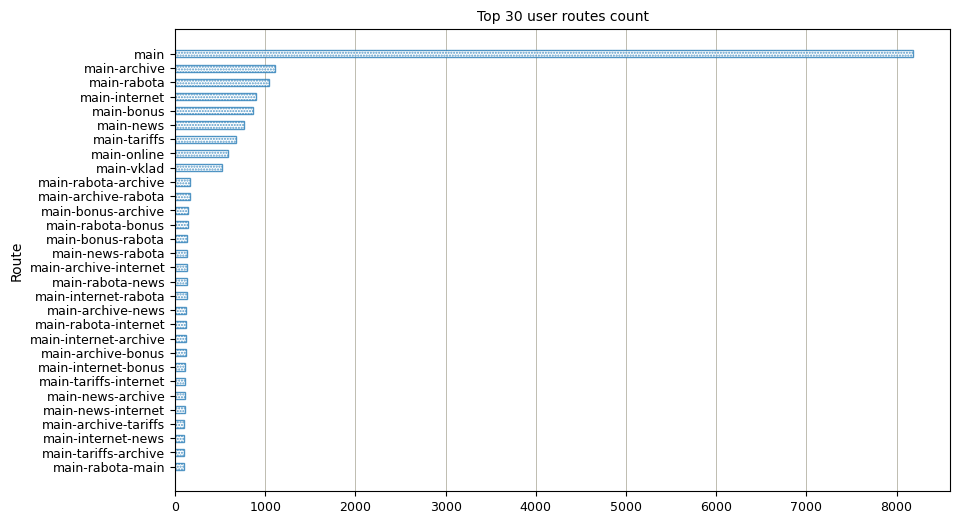

In [36]:
# (7) Plot the result
plt.figure(figsize=(10, 6))
plt.barh(y=solution_sql.rdd.map(lambda x: x[0]).collect(), width=solution_sql.rdd.map(lambda x: x[1]).collect(), color="white", edgecolor="C0", hatch="."*6, height=0.5, alpha=0.75)
plt.yticks(size=9)
plt.xticks(size=9)
plt.ylabel("Route", size=10)
plt.gca().invert_yaxis()
plt.gca().set_axisbelow(True)
plt.title("Top 30 user routes count", size=10)
plt.grid(axis="x", lw=0.5, color="xkcd:cement");

##### <a id="save-result"></a> Save Result

In [37]:
# (8) Save the result
# Overwrite (caution!)
! hdfs dfs -rm -r /data/solution_sql/

Deleted /data/solution_sql


In [38]:
solution_sql.write.format("csv").mode("overwrite").options(header=True, delimiter="\t").save("/data/solution_sql")

In [39]:
# Check
! hdfs dfs -ls /data/solution_sql/

Found 2 items
-rw-r--r--   1 root supergroup          0 2024-01-15 14:24 /data/solution_sql/_SUCCESS
-rw-r--r--   1 root supergroup        644 2024-01-15 14:24 /data/solution_sql/part-00000-d82b4957-a913-4bd9-8697-e88fe00c9348-c000.csv


In [40]:
sc.textFile("/data/solution_sql/*").collect()

['route\tcount',
 'main\t8184',
 'main-archive\t1113',
 'main-rabota\t1047',
 'main-internet\t897',
 'main-bonus\t870',
 'main-news\t769',
 'main-tariffs\t677',
 'main-online\t587',
 'main-vklad\t518',
 'main-rabota-archive\t170',
 'main-archive-rabota\t167',
 'main-bonus-archive\t143',
 'main-rabota-bonus\t139',
 'main-bonus-rabota\t135',
 'main-news-rabota\t135',
 'main-archive-internet\t132',
 'main-rabota-news\t130',
 'main-internet-rabota\t129',
 'main-archive-news\t126',
 'main-rabota-internet\t124',
 'main-internet-archive\t123',
 'main-archive-bonus\t117',
 'main-internet-bonus\t115',
 'main-tariffs-internet\t114',
 'main-news-archive\t113',
 'main-news-internet\t109',
 'main-archive-tariffs\t104',
 'main-internet-news\t103',
 'main-tariffs-archive\t103',
 'main-rabota-main\t94']

In [41]:
# Copy result to local machine for submission
! hdfs dfs -get /data/solution_sql/
! ls -alh ./solution_sql

total 12K
drwxr-xr-x 2 root   users 4.0K Jan 15 14:24 .
drwsrwsr-x 1 jovyan users 4.0K Jan 15 14:24 ..
-rw-r--r-- 1 root   root   644 Jan 15 14:24 part-00000-d82b4957-a913-4bd9-8697-e88fe00c9348-c000.csv
-rw-r--r-- 1 root   root     0 Jan 15 14:24 _SUCCESS


In [42]:
# Clean up
sc.stop()

##### <a id="summary"></a> Summary

In this assignment we have built a report showing top 30 most visited user routes.

To prepare the report, we:
- Copied the source csv file with clickstream events to HDFS,
- Loaded the raw csv file into a Spark DataFrame,
- Applied several transformations with __Spark SQL__ to construct routes for each combination of `user_id` and `session_id`: kept only events before the first occurrence of any error found (also excluding event(s) with the same timestamp as the first error), collected the items of the `event_page` column into one list, then each such collection was squeezed to keep only unique pages with preserved order, and finally such squeezed pages were concatenated together to build routes as strings,
- Grouped, sorted and took top 30 unique routes,
- Finally, plotted and saved the results to a file with required format.

Based on the top 30 routes, the users mostly stay only on the `main` page.